In [11]:
from jax import vmap, jit, config
import jax.numpy as jnp
import jax.scipy.stats as jst
import matplotlib.pyplot as plt
from functools import partial 
import matplotlib.pyplot as plt 
config.update("jax_enable_x64", True)


def X_plus_Y_given_n(r: int, n: int):
    vectorize = lambda func: jit(vmap(func))
    poisson = jst.poisson.pmf

    def condition(mu1, mu2):
        sum_over_r = jnp.arange(0, n + 1)
        calc = lambda r: poisson(k=r, mu=mu1) * poisson(k=n - r, mu=mu2)
        return vectorize(calc)(sum_over_r)

    def joint(mu1, mu2):
        return poisson(k=r, mu=mu1) * poisson(k=n - r, mu=mu2)

    def process(mu1, mu2):
        return joint(mu1, mu2) / jnp.sum(condition(mu1, mu2))

    return (process)


prob = lambda mu1 , mu2 : mu1 / (mu1 +mu2)


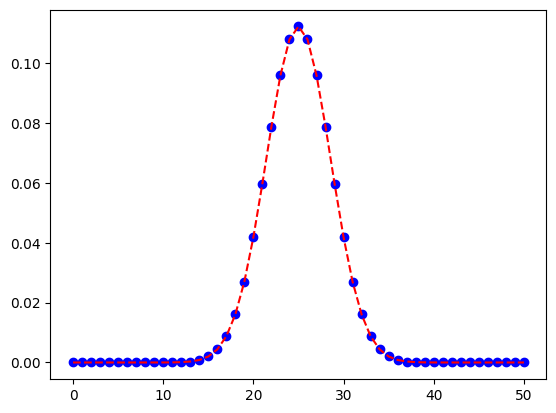

In [12]:
n =50 
mu1, mu2 = 4,4
rs = jnp.arange (0,n+1)
Xs = [X_plus_Y_given_n(r,n) for r in rs]
res = [X(mu1,mu2) for X in Xs]
binom = jst.binom.pmf (p = prob (mu1 , mu2 ) , k =rs , n= n )
plt.plot (rs , res , "bo")
plt.plot (rs , binom , "r--")


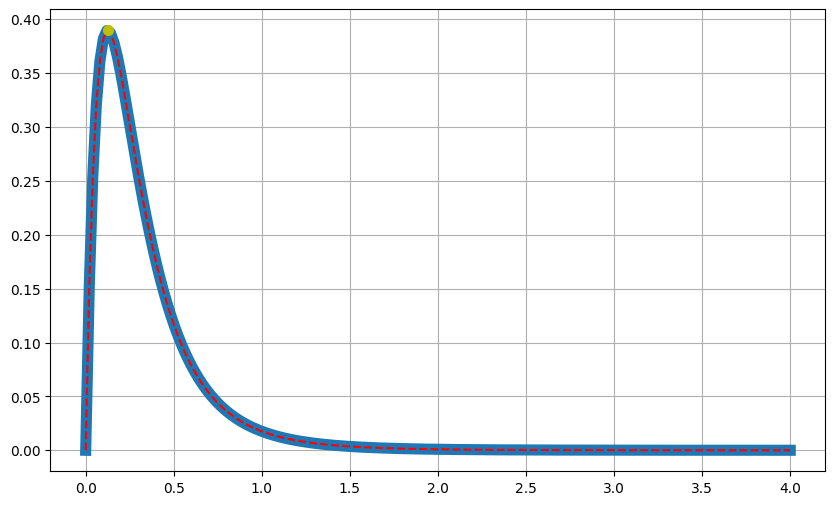

In [14]:
vectorize_prob = vmap (
    fun = partial (prob,mu2 = 1)
)
r =1 
mu1 = jnp.linspace(0,4,200)
mu2 = 1
n= 9 
partial_binom = lambda prob : partial (
    jst.binom.pmf,
    k=r,
    n=n,
    loc = 0
)(p=prob)
vectorize_partial_binom = vmap (
    fun=partial_binom 
)
probs = vectorize_prob (mu1)
res = vectorize_partial_binom (probs)

X = partial (X_plus_Y_given_n (r,n),
             mu2 = 1)
V_X = vmap (
    fun = X
)
method1_res = V_X (mu1)
def max_mu1 (r1,r2 , mu2 ) :
    return (
        jnp.array([r1 * mu2 / r2 ])
    )
maxx = max_mu1 (r , n-r , mu2)
method1_max = V_X (maxx)
plt.figure(figsize=(10,6))
plt.plot (mu1 ,res,linewidth=8 )
plt.plot (mu1 , method1_res , "--r")
plt.plot (maxx ,method1_max,"yo" , markersize =7 )
plt.grid (True)